In [10]:
import numpy as np
import glob2
import datetime
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# from notebooks.demo.Open_ISAS_Grid import travel_time
#
# from notebooks.demo.dev_asso_manual import model
from utils.detection.association import load_detections
from utils.detection.association import compute_grids
from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.constants import EARTH_RADIUS
from utils.physics.sound_model.spherical_sound_model import HomogeneousSphericalSoundModel as HomogeneousSoundModel
from utils.detection.association import compute_candidates, association_is_new, update_valid_grid, update_results

In [11]:
CATALOG_PATH = "/media/rsafran/CORSAIR/OHASISBIO/recensement_stations_OHASISBIO_RS.csv"

In [12]:
CATALOG_PATH = "/media/rsafran/CORSAIR/OHASISBIO/recensement_stations_OHASISBIO_RS.csv"
STATIONS = StationsCatalog(CATALOG_PATH).filter_out_undated().filter_out_unlocated()
STATIONS = STATIONS.by_starting_year(2018)

In [13]:
for st in STATIONS :
    print(st.name)
    print(st.get_pos(include_depth=False))


ELAN
[-56.4602, 62.976]
MADE
[-24.2053, 63.0102]
MADW
[-29.0473, 54.258]
NEAMS
[-31.5758, 83.2423]
RTJ
[-24.3792, 72.372]
SSEIR
[-33.5175, 70.8657]
SSWIR
[-38.5465, 52.9287]
SWAMSbot
[-42.9513, 74.5975]
WKER2
[-46.6015, 60.5475]


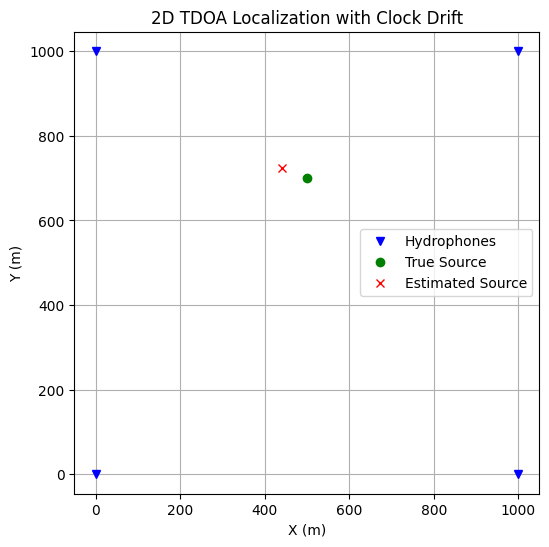

(63.825058004855215, 0.1, array([440.57309472, 723.28263212]), 0.1)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

# Constants
v = 1480  # Speed of sound in water (m/s)

# Hydrophone positions (2D)
hydrophones = np.array([
    [0, 0],
    [1000, 0],
    [0, 1000],
    [1000, 1000]
])

# True source location and emission time
true_source = np.array([500, 700])
true_t0 = 0.0  # emission time in seconds

# Simulate arrival times at each hydrophone
distances = np.linalg.norm(hydrophones - true_source, axis=1)
arrival_times = true_t0 + distances / v

# Simulate clock drift (bias) for each hydrophone
clock_drift = np.array([0.0, 0.1, -0.002, 0.0005])  # in seconds
observed_times = arrival_times + clock_drift

# Reference hydrophone (index 0)
ref_idx = 0
tdoa_observed = observed_times[1:] - observed_times[ref_idx]

# TDOA model function
def tdoa_residuals(params, hydrophones, tdoa_observed, v):
    x, y, t0 = params
    source = np.array([x, y])
    dists = np.linalg.norm(hydrophones - source, axis=1)
    times = dists / v + t0
    tdoa_model = times[1:] - times[0]
    return tdoa_model - tdoa_observed

# Initial guess
initial_guess = np.array([400, 600, 0.1])

# Solve using least squares
result = least_squares(tdoa_residuals, initial_guess, args=(hydrophones, tdoa_observed, v), loss='huber')
estimated_location = result.x[:2]
estimated_t0 = result.x[2]

# Error analysis
position_error = np.linalg.norm(estimated_location - true_source)
t0_error = abs(estimated_t0 - true_t0)

# Visualization
plt.figure(figsize=(6, 6))
plt.plot(hydrophones[:, 0], hydrophones[:, 1], 'bv', label='Hydrophones')
plt.plot(true_source[0], true_source[1], 'go', label='True Source')
plt.plot(estimated_location[0], estimated_location[1], 'rx', label='Estimated Source')
plt.title("2D TDOA Localization with Clock Drift")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

position_error, t0_error, estimated_location, estimated_t0


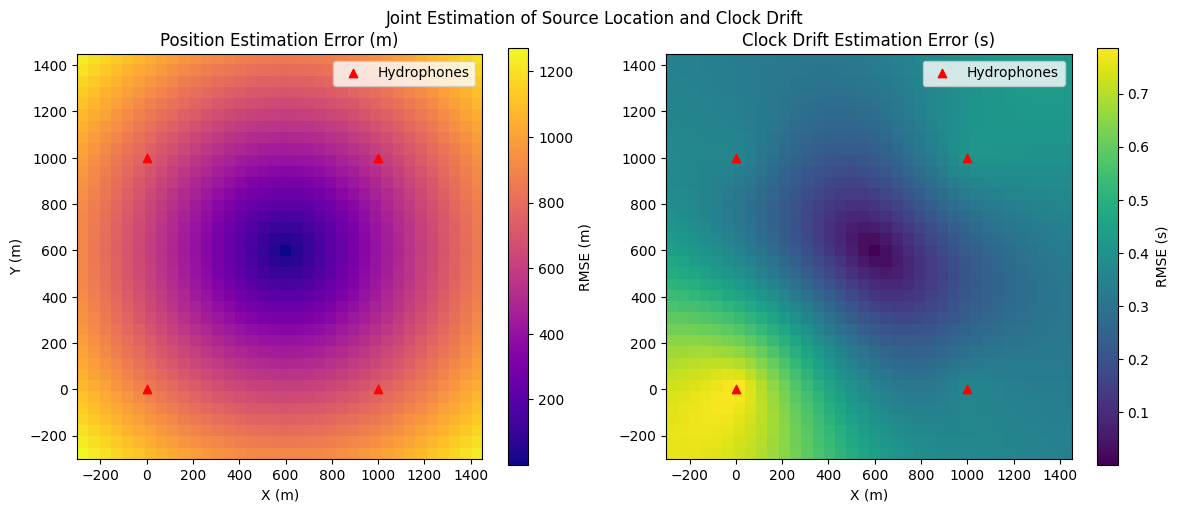

In [15]:
# Simulate joint estimation of source location and clock drift from arrival times
# We'll use nonlinear least squares to estimate both
# Setup
grid_size = 1200
grid_step = 50
x_vals = np.arange(-300, grid_size + 300, grid_step)
y_vals = np.arange(-300, grid_size + 300, grid_step)
grid_points = np.array([[x, y] for x in x_vals for y in y_vals])
# Select event locations on the same grid
event_locations = grid_points
true_drift = np.array([0.0, 0.02, -0.001, 0.0015])  # True clock drift (s)
true_t0 = 0.0

# Extended residual function: source position, t0, and 3 clock drifts (ref hydrophone drift = 0)
def full_residuals(params, hydrophones, observed_times, v):
    x, y, t0, d1, d2, d3 = params
    source = np.array([x, y])
    dists = np.linalg.norm(hydrophones - source, axis=1)
    model_times = dists / v + t0 + np.array([0.0, d1, d2, d3])
    return model_times - observed_times

# Store RMSEs for location and drift
loc_errors = []
drift_errors = []

for source in event_locations:
    # True arrival times
    dists = np.linalg.norm(hydrophones - source, axis=1)
    true_arrival_times = true_t0 + dists / v
    observed_times = true_arrival_times + true_drift

    # Initial guess: location near center, small drift, t0 ~ 0
    init_guess = np.array([600, 600, 0.01, 0.0, 0.0, 0.0])
    result = least_squares(full_residuals, init_guess, args=(hydrophones, observed_times, v))

    # Extract estimated parameters
    est_pos = result.x[:2]
    est_t0 = result.x[2]
    est_drift = np.array([0.0, result.x[3], result.x[4], result.x[5]])

    # Compute errors
    pos_error = np.linalg.norm(est_pos - source)
    drift_error = np.sqrt(np.mean((est_drift - true_drift) ** 2))

    loc_errors.append(pos_error)
    drift_errors.append(drift_error)

# Convert to 2D grid for plotting
loc_errors = np.array(loc_errors).reshape(len(x_vals), len(y_vals))
drift_errors = np.array(drift_errors).reshape(len(x_vals), len(y_vals))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

im1 = ax[0].imshow(loc_errors.T, origin='lower', extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]],
                   cmap='plasma', interpolation='nearest')
ax[0].scatter(hydrophones[:, 0], hydrophones[:, 1], color='red', marker='^', label='Hydrophones')
ax[0].set_title("Position Estimation Error (m)")
ax[0].set_xlabel("X (m)")
ax[0].set_ylabel("Y (m)")
ax[0].legend()
fig.colorbar(im1, ax=ax[0], label='RMSE (m)')

im2 = ax[1].imshow(drift_errors.T, origin='lower', extent=[x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]],
                   cmap='viridis', interpolation='nearest')
ax[1].scatter(hydrophones[:, 0], hydrophones[:, 1], color='red', marker='^', label='Hydrophones')
ax[1].set_title("Clock Drift Estimation Error (s)")
ax[1].set_xlabel("X (m)")
ax[1].legend()
fig.colorbar(im2, ax=ax[1], label='RMSE (s)')

plt.suptitle("Joint Estimation of Source Location and Clock Drift")
plt.tight_layout()
plt.show()


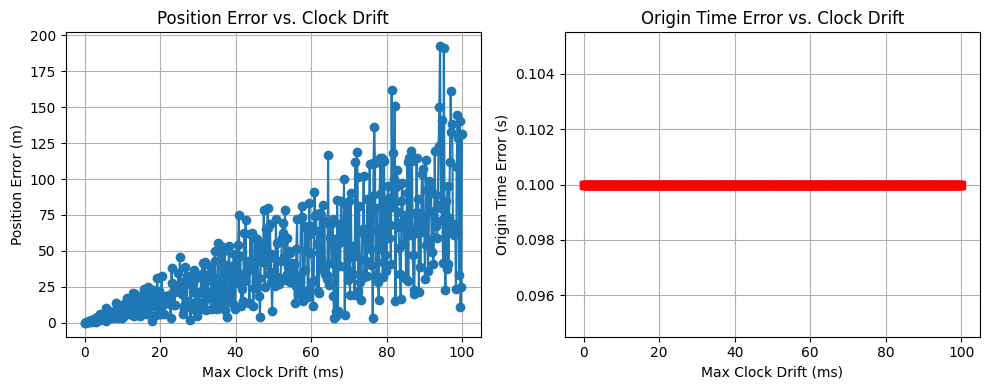

In [16]:
# Vary clock drift magnitudes and analyze their effect

# Clock drift magnitudes (in seconds)
drift_magnitudes = np.linspace(0, 0.1, 500)
position_errors = []
t0_errors = []

# Run simulations
for drift in drift_magnitudes:
    # Create random clock drifts with fixed magnitude
    clock_drift = np.random.uniform(-drift, drift, size=4)

    # Compute observed arrival times
    observed_times = arrival_times + clock_drift
    tdoa_observed = observed_times[1:] - observed_times[ref_idx]

    # Estimate source location using least squares
    result = least_squares(tdoa_residuals, initial_guess, args=(hydrophones, tdoa_observed, v))
    estimated_location = result.x[:2]
    estimated_t0 = result.x[2]

    # Compute errors
    position_errors.append(np.linalg.norm(estimated_location - true_source))
    t0_errors.append(abs(estimated_t0 - true_t0))

# Plotting error vs. drift magnitude
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(drift_magnitudes * 1000, position_errors, 'o-')
plt.xlabel("Max Clock Drift (ms)")
plt.ylabel("Position Error (m)")
plt.title("Position Error vs. Clock Drift")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(drift_magnitudes * 1000, t0_errors, 's-r')
plt.xlabel("Max Clock Drift (ms)")
plt.ylabel("Origin Time Error (s)")
plt.title("Origin Time Error vs. Clock Drift")
plt.grid(True)

plt.tight_layout()
plt.show()


Measured TDOAs: [ -386.07775433  -684.5459357    101.852727    -133.4131108
  -695.54105453 -1021.87910596  -505.92339718  -774.53242217]
Grid search minimum: lat=-37.777778, lon=59.949495, cost=62.11728518


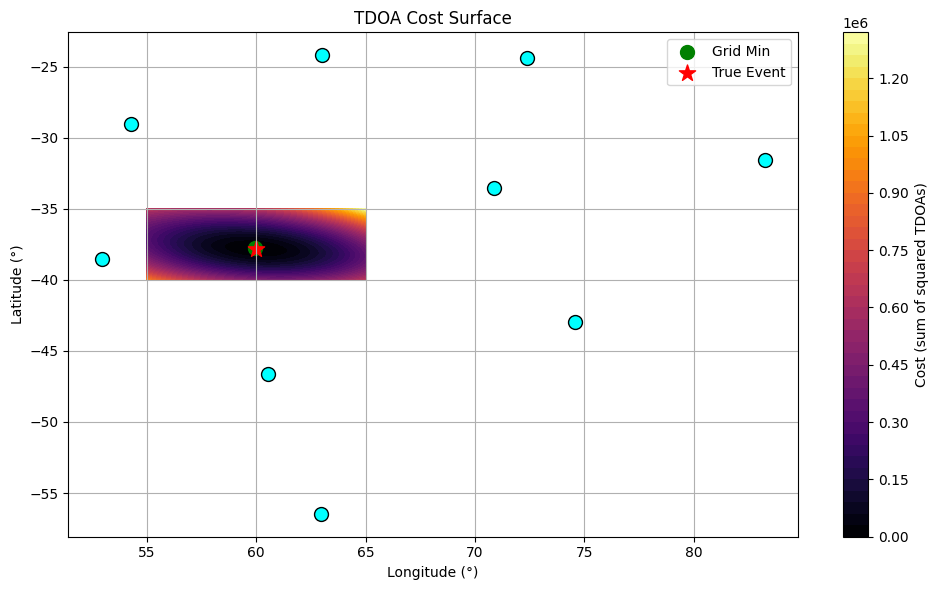

Optimized solution: lat=-37.800000, lon=60.000000, cost=0.00000000
Error distance: 0.00 meters
-24.2053 63.0102 -56.4602 62.976
-29.0473 54.258 -56.4602 62.976
-31.5758 83.2423 -56.4602 62.976
-24.3792 72.372 -56.4602 62.976
-33.5175 70.8657 -56.4602 62.976
-38.5465 52.9287 -56.4602 62.976
-42.9513 74.5975 -56.4602 62.976
-46.6015 60.5475 -56.4602 62.976


/tmp/ipykernel_14248/1329105167.py:191: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(LON, LAT, tdoa_field, levels=[tdoa], colors=[colors[i % len(colors)]],


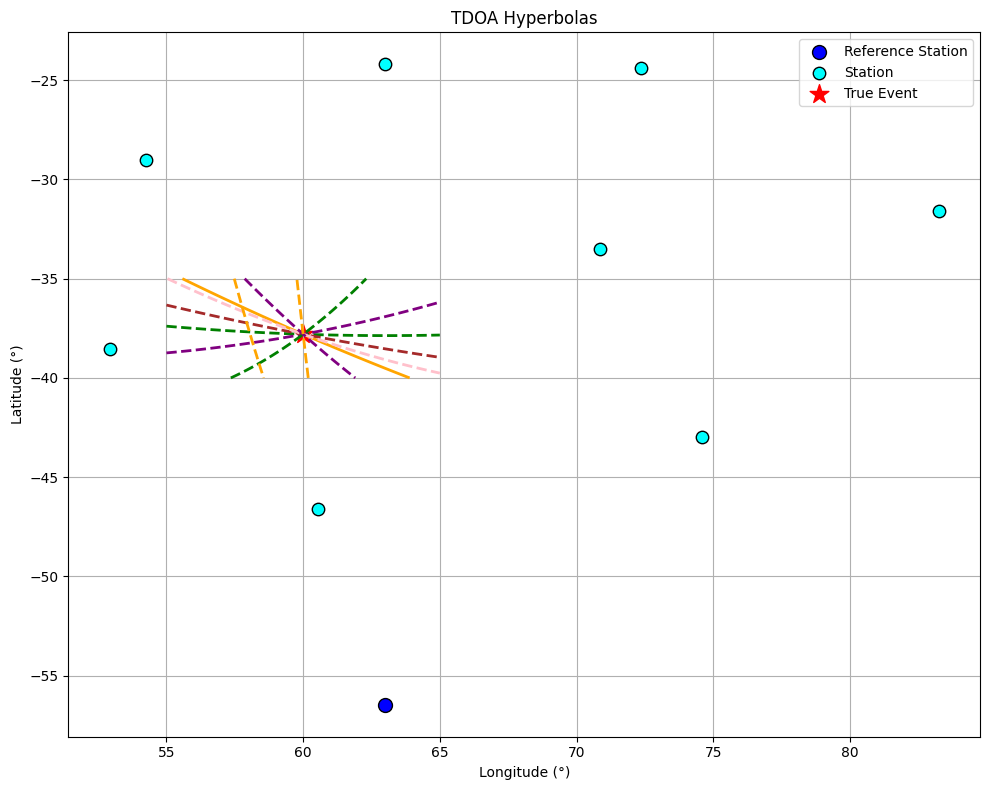

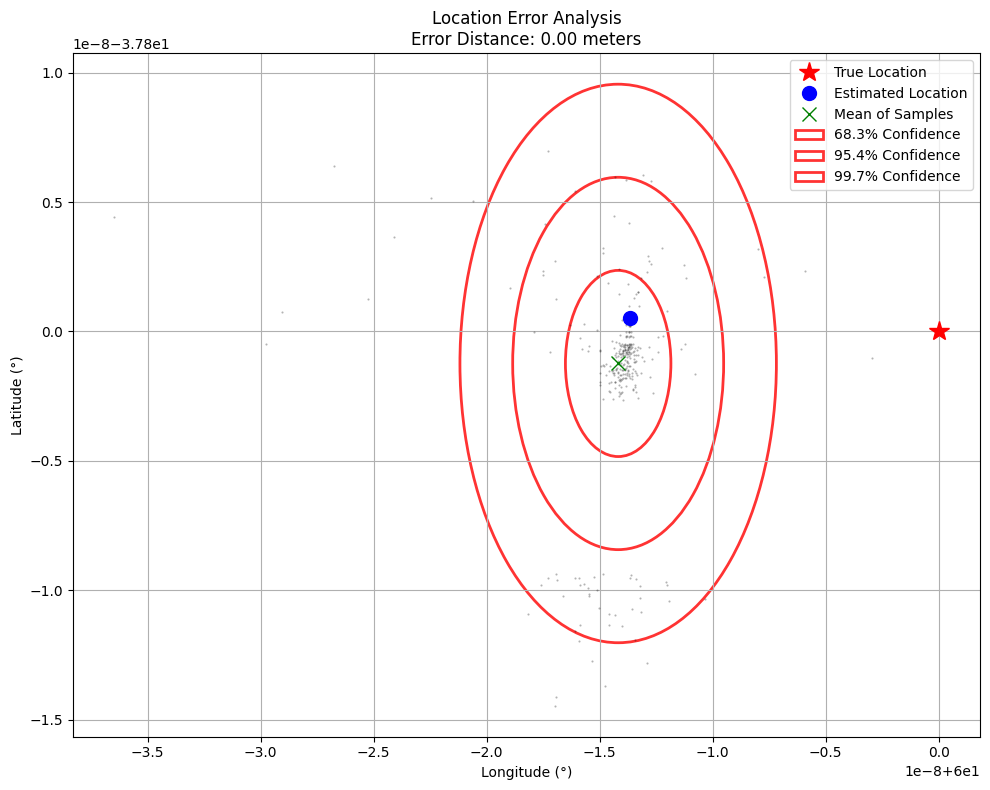

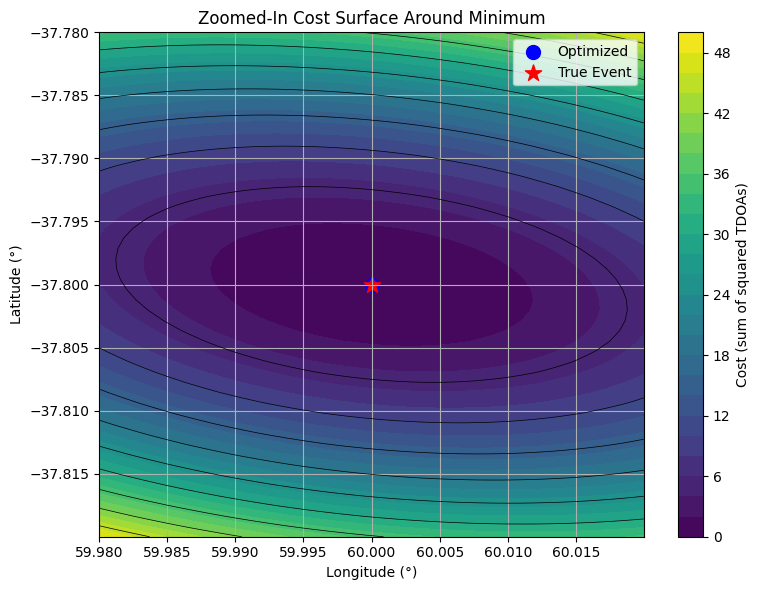

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Geod
from scipy.optimize import minimize
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.special import erf


geod = Geod(ellps="WGS84")

# Improved geodesic distance function - vectorized where possible
def geodesic_distance_grid(lat_grid, lon_grid, station_lat, station_lon):
    """Compute geodesic distances from each grid point to a station."""
    azimuths, backazimuths, distances = geod.inv(
        lon_grid.flatten(), lat_grid.flatten(),
        np.full_like(lon_grid.flatten(), station_lon),
        np.full_like(lat_grid.flatten(), station_lat)
    )

    return distances.reshape(lat_grid.shape)

# Function to calculate the TDOA cost for a single location (for optimization)
def tdoa_cost_function(location, stations, measured_tdoas=None, c=330.0):

    lat, lon = location

    # Calculate distance to all stations
    distances = []
    for st in stations:
        st_lat, st_lon = st.get_pos()
        _, _, dist = geod.inv(lon, lat, st_lon, st_lat)
        distances.append(dist)

    distances = np.array(distances)

    if measured_tdoas is not None:
        ref_dist = distances[0]
        theoretical_tdoas = (distances[1:] - ref_dist) / c
        return np.sum((theoretical_tdoas - measured_tdoas)**2)

    ref_dist = distances[0]
    tdoas = (distances[1:] - ref_dist) / c

    return np.sum(tdoas**2)

# Compute grid-based TDOA cost surface
def compute_tdoa_cost_surface(lats, lons, stations, c=330.0, measured_tdoas=None):
    """Calculate TDOA cost surface across a grid"""
    LAT, LON = np.meshgrid(lats, lons, indexing='ij')

    # Get reference station
    ref_station = stations[0]
    dist_ref = geodesic_distance_grid(LAT, LON, ref_station.get_pos()[0], ref_station.get_pos()[1])

    # Compute TDOAs relative to reference station
    tdoa_grids = []
    for st in stations[1:]:
        dist_st = geodesic_distance_grid(LAT, LON, st.get_pos()[0], st.get_pos()[1])
        tdoa = (dist_st - dist_ref) / c
        tdoa_grids.append(tdoa)

    # If we have measured TDOAs, compute cost against those
    if measured_tdoas is not None:
        cost_surface = np.zeros_like(LAT)
        for i, tdoa_grid in enumerate(tdoa_grids):
            cost_surface += (tdoa_grid - measured_tdoas[i])**2
    else:
        # Otherwise use standard cost (sum of squared TDOAs)
        cost_surface = sum(t**2 for t in tdoa_grids)

    return LAT, LON, cost_surface, tdoa_grids

# Fine optimization using scipy.optimize
def optimize_tdoa_location(initial_guess, stations, measured_tdoas=None, c=330.0):
    """
    Find precise location using numerical optimization
    """
    result = minimize(
        tdoa_cost_function,
        initial_guess,
        args=(stations, measured_tdoas, c),
        method='L-BFGS-B',
        options={'ftol': 1e-10, 'gtol': 1e-10}
    )

    return result

# Function to simulate a measurement with added noise
def simulate_measurement(event_loc, stations, c=330.0, noise_std=0.000):
    """
    Simulate TDOA measurements from a known event location

    Parameters:
    -----------
    event_loc : tuple
        (lat, lon) of event
    stations : list
        List of station objects
    c : float
        Propagation speed
    noise_std : float
        Standard deviation of noise in seconds

    Returns:
    --------
    tdoas : array
        Simulated TDOA measurements with noise
    """
    event_lat, event_lon = event_loc

    # Calculate true distances
    distances = []
    for st in stations:
        st_lat, st_lon = st.get_pos()
        _, _, dist = geod.inv(event_lon, event_lat, st_lon, st_lat)
        distances.append(dist)

    # Calculate TDOAs
    ref_dist = distances[0]
    true_tdoas = (np.array(distances[1:]) - ref_dist) / c

    # Add noise
    noisy_tdoas = true_tdoas + np.random.normal(0, noise_std, len(true_tdoas))

    return noisy_tdoas

# Plot TDOA hyperbolas for visual verification
def plot_tdoa_hyperbolas(stations, event_loc, lats, lons, c=330.0, noise_std=0.0):
    """
    Plot TDOA hyperbolas for visual verification

    Parameters:
    -----------
    stations : list
        List of station objects with get_pos() method
    event_loc : tuple
        (lat, lon) of event location
    lats, lons : arrays
        Grid coordinates
    c : float
        Propagation speed
    noise_std : float
        Standard deviation of noise to add to measurements
    """
    # Generate simulated TDOA measurements
    tdoas = simulate_measurement(event_loc, stations, c, noise_std)

    # Create meshgrid
    LAT, LON = np.meshgrid(lats, lons, indexing='ij')

    # Get reference station
    ref_station = stations[0]

    # Plot each TDOA curve
    plt.figure(figsize=(10, 8))

    # Plot stations
    for i, st in enumerate(stations):
        st_lat, st_lon = st.get_pos()
        if i == 0:
            plt.scatter(st_lon, st_lat, c='blue', s=100, edgecolor='black', label='Reference Station')
        else:
            plt.scatter(st_lon, st_lat, c='cyan', s=80, edgecolor='black', label='Station' if i == 1 else "")

    # Plot event
    event_lat, event_lon = event_loc
    plt.scatter(event_lon, event_lat, c='red', marker='*', s=200, label='True Event')

    # Plot TDOA hyperbolas
    colors = ['green', 'purple', 'orange', 'brown', 'pink']

    for i, (st, tdoa) in enumerate(zip(stations[1:], tdoas)):
        # Calculate theoretical TDOA field
        st_lat, st_lon = st.get_pos()
        ref_lat, ref_lon = stations[0].get_pos()
        print(st_lat,st_lon,ref_lat,ref_lon)
        st_lat = np.full_like(LAT,st_lat)
        st_lon = np.full_like(LON,st_lon)
        ref_lat = np.full_like(LAT,ref_lat)
        ref_lon = np.full_like(LON,ref_lon)
        # Calculate distances
        _, _, dist_ref = geod.inv(LON, LAT, ref_lon, ref_lat)

        _, _, dist_st = geod.inv(LON, LAT, st_lon, st_lat)

        # Calculate TDOA field
        tdoa_field = (dist_st - dist_ref) / c

        # Plot the hyperbola where TDOA = measured TDOA
        plt.contour(LON, LAT, tdoa_field, levels=[tdoa], colors=[colors[i % len(colors)]],
                   linewidths=2, label=f'TDOA {i+1}')

    plt.title('TDOA Hyperbolas')
    plt.xlabel('Longitude (°)')
    plt.ylabel('Latitude (°)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Estimate location error using Monte Carlo sampling
def estimate_error(best_loc, stations, c=330.0, noise_std=0.01, n_samples=100):
    """
    Estimate location error distribution using Monte Carlo simulations

    Parameters:
    -----------
    best_loc : tuple
        (lat, lon) best estimate of event location
    stations : list
        List of station objects
    c : float
        Propagation speed
    noise_std : float
        Standard deviation of noise in seconds
    n_samples : int
        Number of Monte Carlo samples

    Returns:
    --------
    results : list
        List of (lat, lon) results from Monte Carlo simulations
    """
    results = []

    for _ in range(n_samples):
        # Generate noisy TDOAs
        noisy_tdoas = simulate_measurement(best_loc, stations, c, noise_std)

        # Re-optimize with these noisy TDOAs
        result = optimize_tdoa_location(best_loc, stations, noisy_tdoas, c)

        if result.success:
            results.append(result.x)

    return np.array(results)

# Plot confidence ellipse for error visualization
def plot_confidence_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    """
    Plot confidence ellipse representing location uncertainty

    Parameters:
    -----------
    mean : array-like
        Center point of ellipse (x, y)
    cov : 2x2 array
        Covariance matrix
    ax : matplotlib.axes.Axes
        Axes to plot on
    n_std : float
        Number of standard deviations for ellipse size
    **kwargs : dict
        Additional arguments for matplotlib.patches.Ellipse
    """
    cov = np.array(cov)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      **kwargs)

    # Compute eigenvalues and eigenvectors
    eigenvals, eigenvecs = np.linalg.eigh(cov)

    # Calculate angle in degrees
    angle = np.degrees(np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0]))

    # Calculate scale to make ellipse radius match n_std
    scale_x = np.sqrt(eigenvals[0]) * n_std
    scale_y = np.sqrt(eigenvals[1]) * n_std

    # Create scaling transform
    transf = transforms.Affine2D() \
        .rotate_deg(angle) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Plot error analysis with Monte Carlo samples
def plot_error_analysis(true_loc, est_loc, mc_samples):
    """
    Plot error analysis with Monte Carlo samples and confidence ellipse

    Parameters:
    -----------
    true_loc : tuple
        (lat, lon) of true event location
    est_loc : tuple
        (lat, lon) of estimated event location
    mc_samples : array
        Array of (lat, lon) pairs from Monte Carlo simulation
    """
    # Calculate mean and covariance of samples
    mean = np.mean(mc_samples, axis=0)
    cov = np.cov(mc_samples.T)

    # Create plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot Monte Carlo samples
    ax.plot(mc_samples[:, 1], mc_samples[:, 0], 'k.', markersize=1, alpha=0.3)

    # Plot true and estimated locations
    ax.plot(true_loc[1], true_loc[0], 'r*', markersize=15, label='True Location')
    ax.plot(est_loc[1], est_loc[0], 'bo', markersize=10, label='Estimated Location')
    ax.plot(mean[1], mean[0], 'gx', markersize=10, label='Mean of Samples')

    # Plot confidence ellipses (68%, 95%, 99.7%)
    for n_std, alpha in zip([1, 2, 3], [0.3, 0.2, 0.1]):
        confidence = erf(n_std / np.sqrt(2)) * 100
        plot_confidence_ellipse(
            [mean[1], mean[0]],
            [[cov[1, 1], cov[1, 0]], [cov[0, 1], cov[0, 0]]],
            ax, n_std=n_std, edgecolor='red', facecolor='none',
            alpha=0.8, linewidth=2,
            label=f'{confidence:.1f}% Confidence'
        )

    # Calculate and display error metrics
    error_dist = geod.inv(true_loc[1], true_loc[0], est_loc[1], est_loc[0])[2]
    ax.set_title(f'Location Error Analysis\nError Distance: {error_dist:.2f} meters')
    ax.set_xlabel('Longitude (°)')
    ax.set_ylabel('Latitude (°)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

#-----------------------------------------
# EXAMPLE USAGE - Copy and adapt this part
#-----------------------------------------

# Step 1: Define your stations
stations = STATIONS

# Step 2: Define the true event location (for testing)
event_loc = (-37.8, 60)  # Somewhere in the Bay Area

# Step 3: Define grid search area with appropriate resolution
lats = np.linspace(-35, -40, 100)
lons = np.linspace(55,65, 100)

# Step 4: Define parameters
c = 1430.0  # Speed of sound in m/s (adjust as needed)
noise_std = 1e-6 # Standard deviation of noise in seconds

# Step 5: Generate simulated TDOA measurements
measured_tdoas = simulate_measurement(event_loc, stations, c, noise_std)
print(f"Measured TDOAs: {measured_tdoas}")

# Step 6: Compute cost surface
LAT, LON, cost_surface, tdoa_grids = compute_tdoa_cost_surface(
    lats, lons, stations, c, measured_tdoas
)

# Step 7: Find initial solution using grid search
min_idx = np.unravel_index(np.argmin(cost_surface), cost_surface.shape)
min_lat, min_lon = LAT[min_idx], LON[min_idx]
min_cost = cost_surface[min_idx]
print(f"Grid search minimum: lat={min_lat:.6f}, lon={min_lon:.6f}, cost={min_cost:.8f}")

# Step 8: Plot initial cost surface
plt.figure(figsize=(10, 6))
plt.contourf(LON, LAT, cost_surface, levels=50, cmap="inferno")
plt.colorbar(label="Cost (sum of squared TDOAs)")
for st in stations:
    st_lat, st_lon = st.get_pos()
    plt.scatter(st_lon, st_lat, c='cyan', edgecolor='black', s=100)
plt.scatter(min_lon, min_lat, c='green', marker='o', s=100, label='Grid Min')
plt.scatter(event_loc[1], event_loc[0], c='red', marker='*', s=150, label='True Event')
plt.title("TDOA Cost Surface")
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Refine solution with optimization
initial_guess = (min_lat, min_lon)
result = optimize_tdoa_location(initial_guess, stations, measured_tdoas, c)

if result.success:
    opt_lat, opt_lon = result.x
    opt_cost = result.fun
    print(f"Optimized solution: lat={opt_lat:.6f}, lon={opt_lon:.6f}, cost={opt_cost:.8f}")

    # Calculate error distance
    error_dist = geod.inv(event_loc[1], event_loc[0], opt_lon, opt_lat)[2]
    print(f"Error distance: {error_dist:.2f} meters")
else:
    print("Optimization failed:", result.message)
    opt_lat, opt_lon = min_lat, min_lon

# Step 10: Plot TDOA hyperbolas for validation
plot_tdoa_hyperbolas(stations, event_loc, lats, lons, c, noise_std)

# Step 11: Run Monte Carlo simulations for error analysis
mc_samples = estimate_error((opt_lat, opt_lon), stations, c, noise_std, n_samples=500)

# Step 12: Plot error analysis
plot_error_analysis(event_loc, (opt_lat, opt_lon), mc_samples)

# Optional: Plot zoomed cost surface around minimum
# Define zoom window size (e.g., ±0.02° around the minimum)
zoom_range_lat = 0.02
zoom_range_lon = 0.02

lats_zoom = np.linspace(opt_lat - zoom_range_lat, opt_lat + zoom_range_lat, 50)
lons_zoom = np.linspace(opt_lon - zoom_range_lon, opt_lon + zoom_range_lon, 50)

# Compute zoomed cost surface
LAT_zoom, LON_zoom, cost_zoom, _ = compute_tdoa_cost_surface(
    lats_zoom, lons_zoom, stations, c, measured_tdoas
)

# Find minimum on zoomed grid
min_idx_zoom = np.unravel_index(np.argmin(cost_zoom), cost_zoom.shape)
min_lat_zoom, min_lon_zoom = LAT_zoom[min_idx_zoom], LON_zoom[min_idx_zoom]

# Plot zoomed cost surface
plt.figure(figsize=(8, 6))
plt.contourf(LON_zoom, LAT_zoom, cost_zoom, levels=30, cmap="viridis")
plt.colorbar(label="Cost (sum of squared TDOAs)")
plt.contour(LON_zoom, LAT_zoom, cost_zoom, levels=10, colors='black', linewidths=0.5)
plt.scatter(opt_lon, opt_lat, c='blue', marker='o', s=100, label='Optimized')
plt.scatter(event_loc[1], event_loc[0], c='red', marker='*', s=150, label='True Event')
plt.title("Zoomed-In Cost Surface Around Minimum")
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

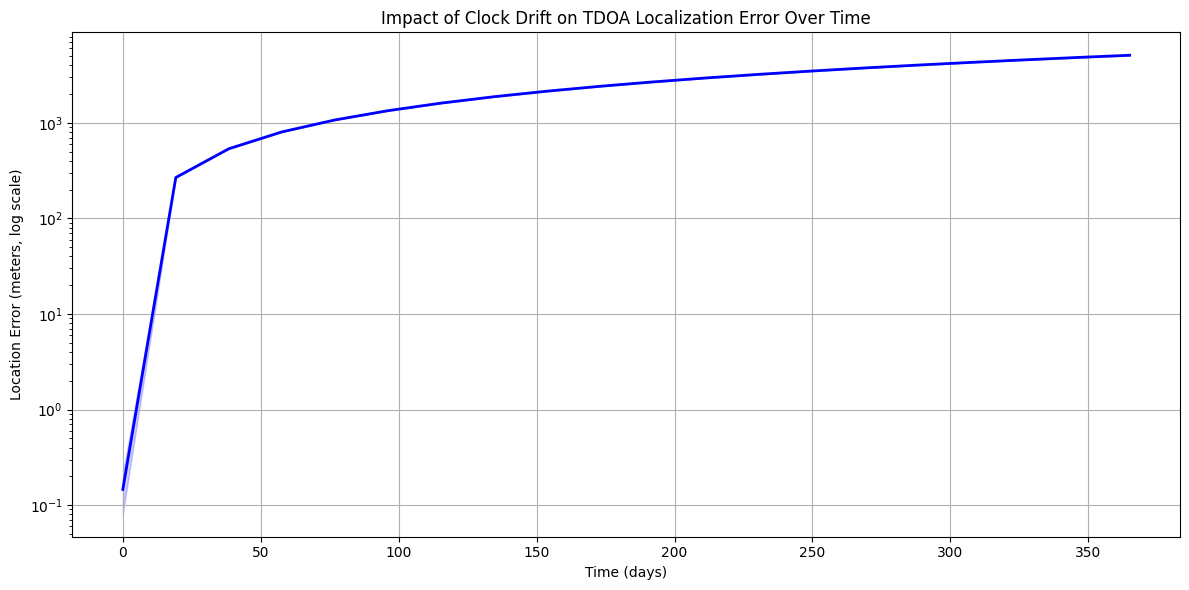

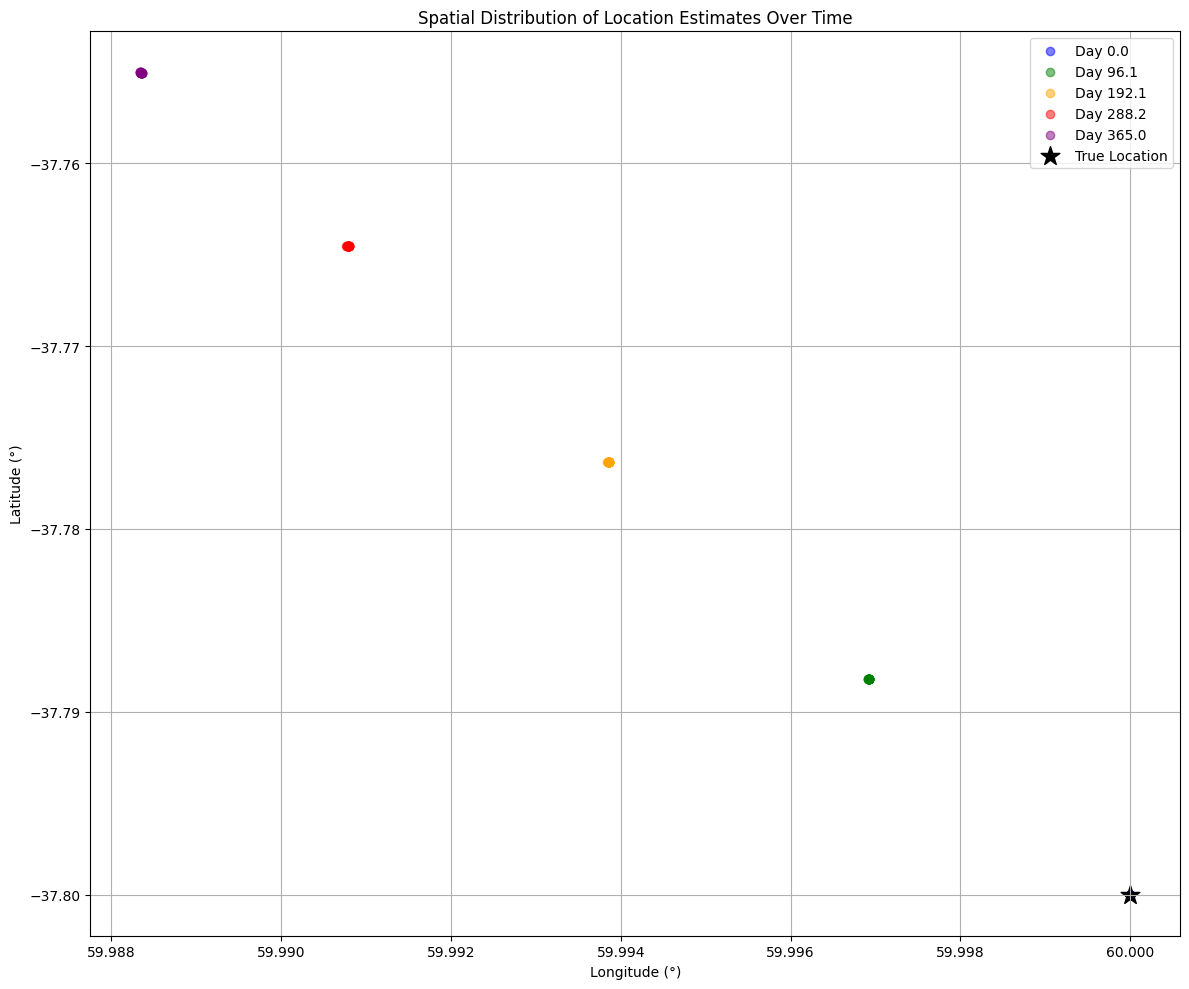

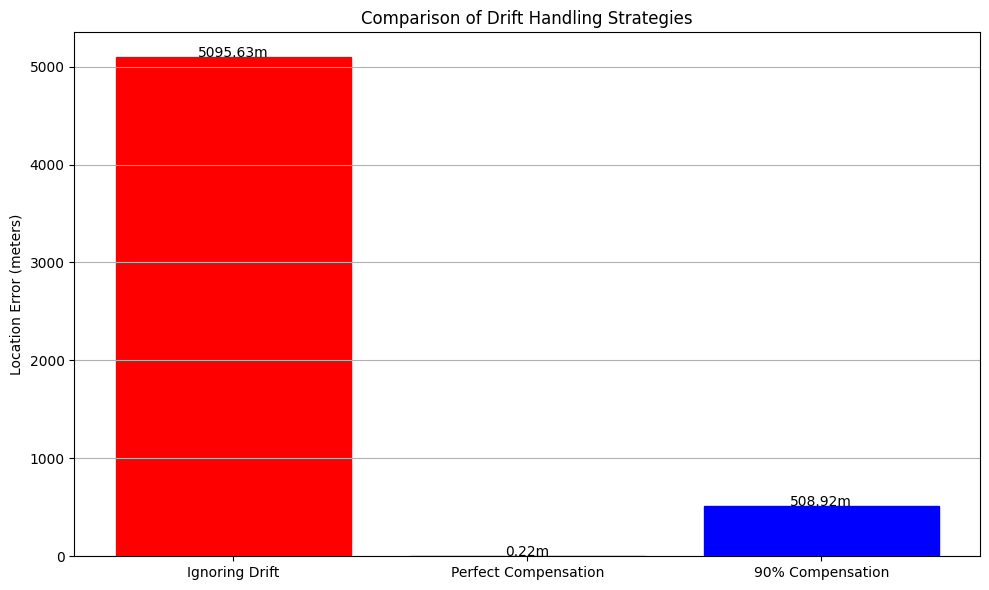

Clock drift rate: 10 ppm
After one year, the clock error is: 315.360000 seconds
With sound speed of 1430.0 m/s, this corresponds to a distance error of: 450964.80 meters
Maximum location error due to drift after one year: 5095.75 meters


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Geod
from scipy.optimize import minimize
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.special import erf

# We'll use the existing Station class from station.py
# No need to define a new Station class as it's already imported

# Set up geodesic calculations on WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Function to simulate TDOA measurements with clock drift
def simulate_measurement_with_drift(event_loc, stations, c=330.0, noise_std=0.0, time_elapsed_seconds=0):
    """
    Simulate TDOA measurements from a known event location, accounting for clock drift

    Parameters:
    -----------
    event_loc : tuple
        (lat, lon) of event
    stations : list
        List of station objects
    c : float
        Propagation speed
    noise_std : float
        Standard deviation of noise in seconds
    time_elapsed_seconds : float
        Time elapsed since system initialization in seconds

    Returns:
    --------
    tdoas : array
        Simulated TDOA measurements with noise and clock drift
    """
    event_lat, event_lon = event_loc

    # Calculate true distances
    distances = []
    for st in stations:
        st_lat, st_lon = st.get_pos()
        _, _, dist = geod.inv(event_lon, event_lat, st_lon, st_lat)
        distances.append(dist)

    # Calculate TDOAs
    ref_dist = distances[0]
    true_tdoas = (np.array(distances[1:]) - ref_dist) / c

    # Add clock drift effects
    drift_affected_tdoas = true_tdoas.copy()
    for i, st in enumerate(stations[1:]):
        # Apply clock drift to this station (reference station is 0)
        # Check if station has clock_drift_ppm in other_kwargs
        if hasattr(st, 'other_kwargs') and 'clock_drift_ppm' in st.other_kwargs:
            clock_error = st.get_clock_error(time_elapsed_seconds)
            drift_affected_tdoas[i] += clock_error

    # Add random noise
    noisy_tdoas = drift_affected_tdoas + np.random.normal(0, noise_std, len(drift_affected_tdoas))

    return noisy_tdoas

# Function to analyze the impact of clock drift over time
def analyze_clock_drift_impact(event_loc, stations, c=330.0, noise_std=0.0,
                              time_points=None, n_samples=10):
    """
    Analyze how clock drift affects localization accuracy over time

    Parameters:
    -----------
    event_loc : tuple
        (lat, lon) of event
    stations : list
        List of station objects
    c : float
        Propagation speed
    noise_std : float
        Standard deviation of random noise
    time_points : array
        Time points to analyze (in seconds)
    n_samples : int
        Number of Monte Carlo samples per time point

    Returns:
    --------
    results : dict
        Dictionary with analysis results
    """
    if time_points is None:
        # Default: analyze from 0 to 1 year in 10 steps
        seconds_in_year = 365 * 24 * 60 * 60
        time_points = np.linspace(0, seconds_in_year, 10)

    results = {
        'time_points': time_points,
        'mean_error': [],
        'std_error': [],
        'locations': []
    }

    # Loop through each time point
    for t in time_points:
        errors = []
        locations = []

        # Run multiple simulations for this time point
        for _ in range(n_samples):
            # Generate measurements with clock drift at this time
            tdoas = simulate_measurement_with_drift(event_loc, stations, c, noise_std, t)

            # Get initial guess near the true location (add some uncertainty)
            initial_guess = (
                event_loc[0] + np.random.normal(0, 0.01),
                event_loc[1] + np.random.normal(0, 0.01)
            )

            # Optimize location using measurements (unaware of clock drift)
            result = optimize_tdoa_location(initial_guess, stations, tdoas, c)

            if result.success:
                est_lat, est_lon = result.x
                # Calculate error distance
                _, _, error_dist = geod.inv(event_loc[1], event_loc[0], est_lon, est_lat)
                errors.append(error_dist)
                locations.append((est_lat, est_lon))

        if errors:
            results['mean_error'].append(np.mean(errors))
            results['std_error'].append(np.std(errors))
            results['locations'].append(locations)
        else:
            results['mean_error'].append(np.nan)
            results['std_error'].append(np.nan)
            results['locations'].append([])

    return results

# Plot the drift impact over time
def plot_drift_impact(results, event_loc=None):
    """Plot the impact of clock drift on localization error over time"""
    time_days = results['time_points'] / (24 * 60 * 60)

    plt.figure(figsize=(12, 6))

    # Plot mean error with error bands
    plt.plot(time_days, results['mean_error'], 'b-', linewidth=2)
    plt.fill_between(
        time_days,
        np.array(results['mean_error']) - np.array(results['std_error']),
        np.array(results['mean_error']) + np.array(results['std_error']),
        alpha=0.2, color='blue'
    )

    plt.xlabel('Time (days)')
    plt.ylabel('Location Error (meters)')
    plt.title('Impact of Clock Drift on TDOA Localization Error Over Time')
    plt.grid(True)

    # Add log scale option if error grows rapidly
    if max(results['mean_error']) > 10 * min([e for e in results['mean_error'] if e > 0]):
        plt.yscale('log')
        plt.ylabel('Location Error (meters, log scale)')

    plt.tight_layout()
    plt.show()

    # Plot the spatial distribution of errors at different time points
    if event_loc and results['locations']:
        plt.figure(figsize=(12, 10))

        # Select a few representative time points to display
        indices = [0, len(time_days)//4, len(time_days)//2, 3*len(time_days)//4, -1]
        colors = ['blue', 'green', 'orange', 'red', 'purple']

        for idx, color in zip(indices, colors):
            if idx < len(time_days) and results['locations'][idx]:
                locs = np.array(results['locations'][idx])
                plt.scatter(locs[:, 1], locs[:, 0], alpha=0.5, color=color,
                           label=f'Day {time_days[idx]:.1f}')

        # Plot true event location
        plt.scatter(event_loc[1], event_loc[0], marker='*', color='black', s=200,
                   label='True Location')

        plt.xlabel('Longitude (°)')
        plt.ylabel('Latitude (°)')
        plt.title('Spatial Distribution of Location Estimates Over Time')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Modified TDOA cost function and optimization (unchanged from your original code)
def tdoa_cost_function(location, stations, measured_tdoas=None, c=330.0):
    lat, lon = location

    # Calculate distance to all stations
    distances = []
    for st in stations:
        st_lat, st_lon = st.get_pos()
        _, _, dist = geod.inv(lon, lat, st_lon, st_lat)
        distances.append(dist)

    distances = np.array(distances)

    if measured_tdoas is not None:
        ref_dist = distances[0]
        theoretical_tdoas = (distances[1:] - ref_dist) / c
        return np.sum((theoretical_tdoas - measured_tdoas)**2)

    ref_dist = distances[0]
    tdoas = (distances[1:] - ref_dist) / c

    return np.sum(tdoas**2)

def optimize_tdoa_location(initial_guess, stations, measured_tdoas=None, c=330.0):
    """Find precise location using numerical optimization"""
    result = least_squares(
        tdoa_cost_function,
        initial_guess,
        args=(stations, measured_tdoas, c),
        method='trf', loss= "soft_l1"
    )

    return result

# Analyze clock drift calibration strategies
def analyze_calibration_strategies(event_loc, stations, c=330.0, noise_std=0.0,
                                  time_elapsed_seconds=365*24*60*60):
    """
    Analyze different strategies for handling clock drift

    Parameters:
    -----------
    event_loc : tuple
        (lat, lon) of event
    stations : list
        List of station objects
    c : float
        Propagation speed
    noise_std : float
        Standard deviation of random noise
    time_elapsed_seconds : float
        Time elapsed since system initialization in seconds

    Returns:
    --------
    results : dict
        Dictionary with analysis results
    """
    results = {
        'method': [],
        'mean_error': [],
        'std_error': [],
        'bias': []
    }

    # Generate measurements with clock drift
    tdoas_with_drift = simulate_measurement_with_drift(
        event_loc, stations, c, noise_std, time_elapsed_seconds
    )

    # Method 1: Standard approach (ignoring drift)
    initial_guess = (
        event_loc[0] + np.random.normal(0, 0.01),
        event_loc[1] + np.random.normal(0, 0.01)
    )

    result = optimize_tdoa_location(initial_guess, stations, tdoas_with_drift, c)

    if result.success:
        est_lat, est_lon = result.x
        _, _, error_dist = geod.inv(event_loc[1], event_loc[0], est_lon, est_lat)
        results['method'].append('Ignoring Drift')
        results['mean_error'].append(error_dist)
        results['std_error'].append(0)
        results['bias'].append((est_lat - event_loc[0], est_lon - event_loc[1]))

    # Method 2: With known drift compensation
    # Create a copy of stations with drift information set to zero for compensation
    from copy import deepcopy
    compensated_stations = []
    for st in stations:
        # Create a new station with the same parameters but zero drift
        st_copy = deepcopy(st)
        if hasattr(st_copy, 'other_kwargs'):
            st_copy.other_kwargs["clock_drift_ppm"] = 0
        compensated_stations.append(st_copy)

    # Generate drift-free TDOAs using compensated stations
    tdoas_compensated = simulate_measurement_with_drift(
        event_loc, compensated_stations, c, noise_std, 0
    )

    result = optimize_tdoa_location(initial_guess, compensated_stations, tdoas_compensated, c)

    if result.success:
        est_lat, est_lon = result.x
        _, _, error_dist = geod.inv(event_loc[1], event_loc[0], est_lon, est_lat)
        results['method'].append('Perfect Compensation')
        results['mean_error'].append(error_dist)
        results['std_error'].append(0)
        results['bias'].append((est_lat - event_loc[0], est_lon - event_loc[1]))

    # Method 3: With estimated drift compensation (simulating 90% accurate estimation)
    partially_compensated_stations = []
    for st in stations:
        st_copy = deepcopy(st)
        if hasattr(st_copy, 'other_kwargs') and 'clock_drift_ppm' in st_copy.other_kwargs:
            # Reduce drift to 10% of original (90% compensated)
            st_copy.other_kwargs["clock_drift_ppm"] *= 0.1
        partially_compensated_stations.append(st_copy)

    # Generate partially compensated TDOAs
    tdoas_partial = simulate_measurement_with_drift(
        event_loc, partially_compensated_stations, c, noise_std, time_elapsed_seconds
    )

    result = optimize_tdoa_location(initial_guess, partially_compensated_stations, tdoas_partial, c)

    if result.success:
        est_lat, est_lon = result.x
        _, _, error_dist = geod.inv(event_loc[1], event_loc[0], est_lon, est_lat)
        results['method'].append('90% Compensation')
        results['mean_error'].append(error_dist)
        results['std_error'].append(0)
        results['bias'].append((est_lat - event_loc[0], est_lon - event_loc[1]))

    return results

# Plot calibration strategy results
def plot_calibration_comparison(results):
    """Plot comparison of different calibration strategies"""
    plt.figure(figsize=(10, 6))

    methods = results['method']
    errors = results['mean_error']

    bars = plt.bar(methods, errors)

    # Color the bars
    colors = ['red', 'green', 'blue']
    for bar, color in zip(bars, colors):
        bar.set_color(color)

    plt.ylabel('Location Error (meters)')
    plt.title('Comparison of Drift Handling Strategies')
    plt.grid(True, axis='y')

    # Add error values above bars
    for i, v in enumerate(errors):
        plt.text(i, v + 0.1, f'{v:.2f}m', ha='center')

    plt.tight_layout()
    plt.show()

# Example usage with your existing Station class
def run_clock_drift_analysis():
    # Create stations with one having a clock drift
    # We'll create instances of your Station class with appropriate parameters
    from pathlib import Path
    import datetime

    # Define base parameters for stations
    base_params = {
        'path': "/path/to/data",  # This path isn't used in our simulation
        'date_start': datetime.datetime.now(),
        'date_end': datetime.datetime.now() + datetime.timedelta(days=365),
        'dataset': "simulation"
    }

    # Define the true event location
    event_loc = (-37.8, 60.0)

    # Define parameters
    c = 1430.0  # Speed of sound in m/s (for underwater applications)
    noise_std = 1e-6  # Standard deviation of noise in seconds

    # Define time points for analysis (from 0 to 1 year)
    seconds_in_year = 365 * 24 * 60 * 60
    time_points = np.linspace(0, seconds_in_year, 20)

    # Analyze impact of clock drift over time
    results = analyze_clock_drift_impact(
        event_loc, stations, c, noise_std, time_points, n_samples=20
    )

    # Plot the results
    plot_drift_impact(results, event_loc)

    # Analyze calibration strategies
    cal_results = analyze_calibration_strategies(
        event_loc, stations, c, noise_std, seconds_in_year
    )

    # Plot calibration comparison
    plot_calibration_comparison(cal_results)

    # Print additional information
    print(f"Clock drift rate: 10 ppm")
    print(f"After one year, the clock error is: {10e-6 * seconds_in_year:.6f} seconds")
    print(f"With sound speed of {c} m/s, this corresponds to a distance error of: "
          f"{10e-6 * seconds_in_year * c:.2f} meters")
    print(f"Maximum location error due to drift after one year: {max(results['mean_error']):.2f} meters")

if __name__ == "__main__":
    run_clock_drift_analysis()

OHASISBIO 2018 Stations:
- ELAN: (-56.46, 62.98), Clock Drift: -0.0222 ppm
- MADE: (-24.21, 63.01), Clock Drift: -0.798 ppm
- MADW: (-29.05, 54.26), Clock Drift: 0.002 ppm
- NEAMS: (-31.58, 83.24), Clock Drift: 0.2601 ppm
- RTJ: (-24.38, 72.37), Clock Drift: 0.03 ppm
- SSEIR: (-33.52, 70.87), Clock Drift: -0.2861 ppm
- SSWIR: (-38.55, 52.93), Clock Drift: 0.0346 ppm
- SWAMSbot: (-42.95, 74.60), Clock Drift: 0.0048 ppm
- WKER2: (-46.60, 60.55), Clock Drift: -0.0203 ppm
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
not invertible
no

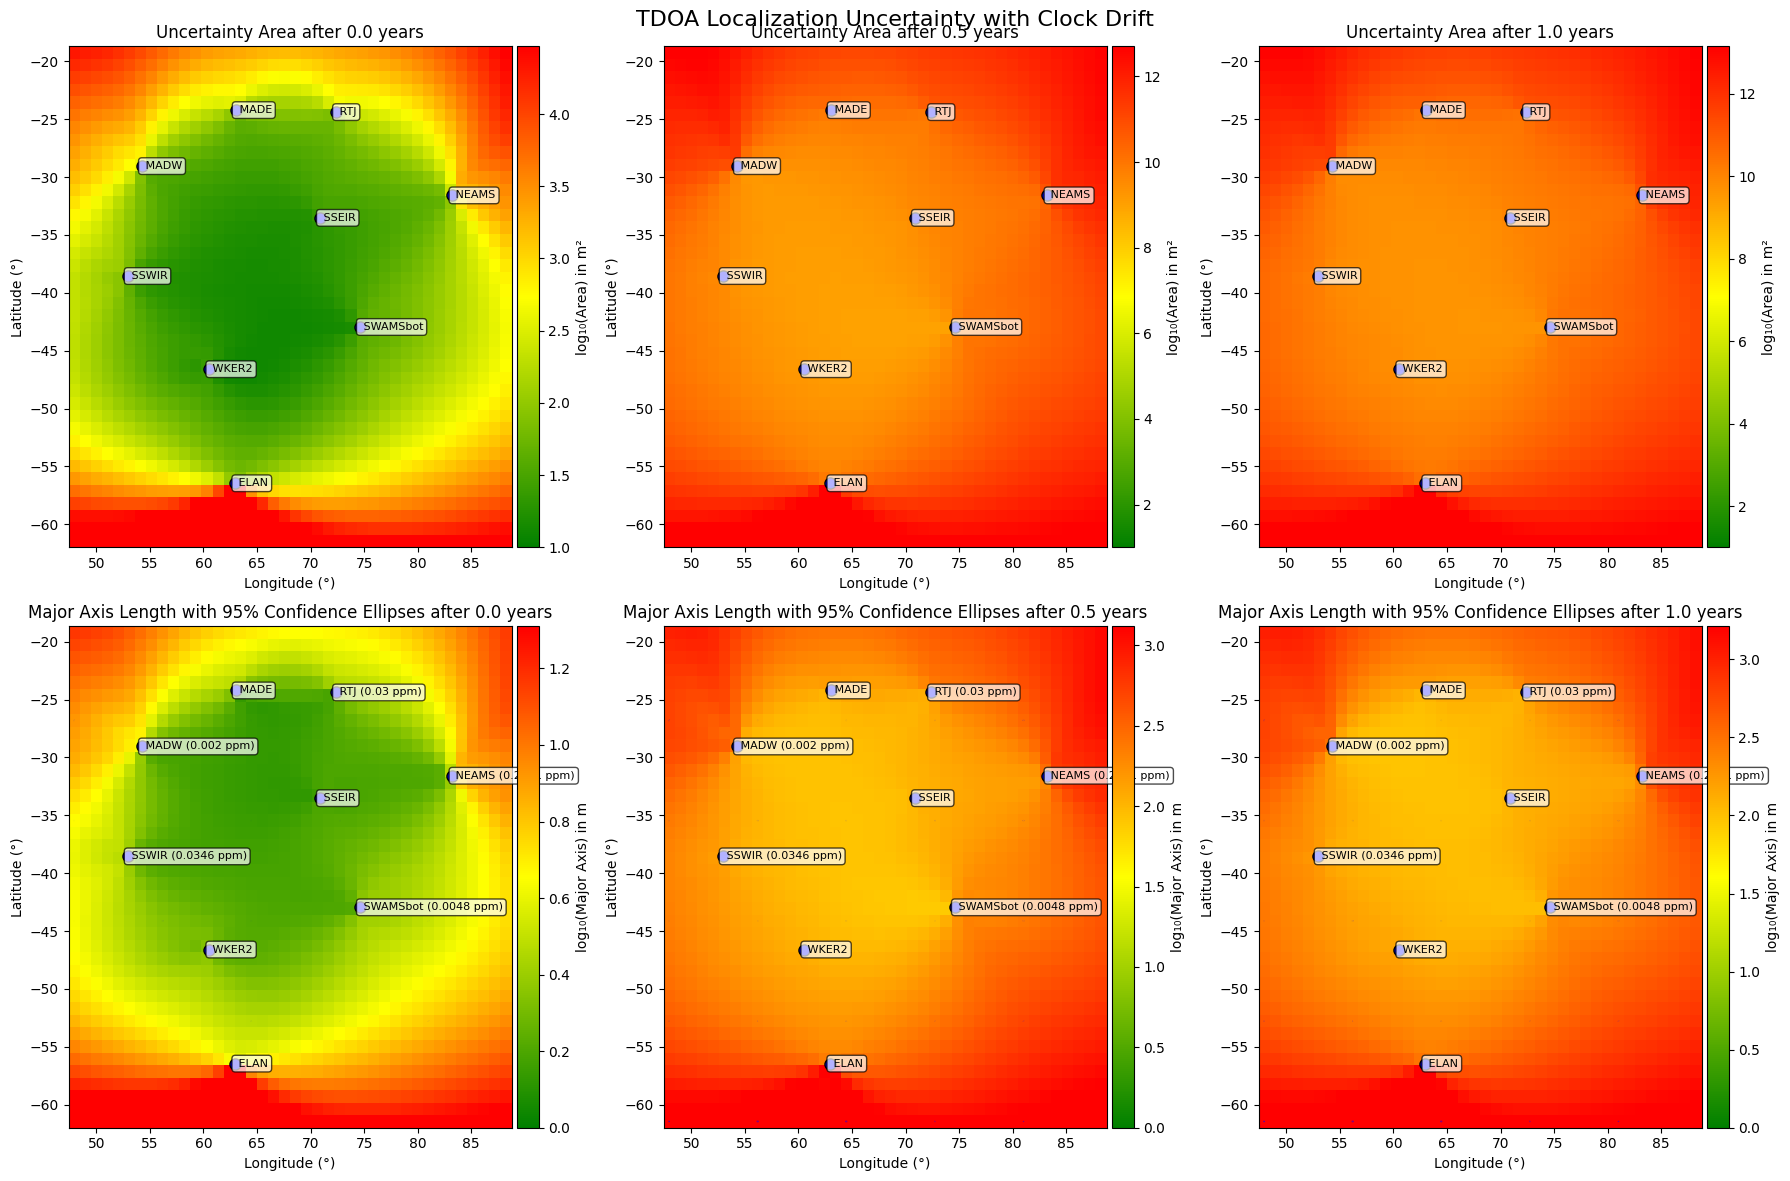


Analyzing effect of different clock drift values...

Uncertainty at array center point after 1 year:
Location: (-36.36, 66.09)
----------------------------------------------------------------------
 Clock Drift (ppm)   | Semi-Major (m)  | Semi-Minor (m)  |   Area (km²)   
----------------------------------------------------------------------
         0           |      69.08      |      1.53       |      0.00      
         1           |     100.99      |      50.56      |      0.02      
         5           |     101.03      |      50.56      |      0.02      
         10          |     101.03      |      50.57      |      0.02      
         20          |     101.04      |      50.57      |      0.02      


In [19]:
mport numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from pyproj import Geod
from scipy.optimize import minimize
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Set up geodesic calculations on WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Function to calculate the Cramér-Rao Lower Bound (CRLB) for TDOA localization
def calculate_crlb(event_loc, stations, c=1430.0, tdoa_std=1e-3, time_elapsed_seconds=0):
    """
    Calculate the CRLB for TDOA localization

    Parameters:
    -----------
    event_loc : tuple
        (lat, lon) of event
    stations : list
        List of station objects
    c : float
        Propagation speed (sound in water)
    tdoa_std : float
        Standard deviation of TDOA measurements in seconds
    time_elapsed_seconds : float
        Time elapsed since system initialization in seconds

    Returns:
    --------
    cov_matrix : ndarray
        2x2 covariance matrix in lat-lon coordinates
    """
    # Get station positions
    n_stations = len(stations)
    station_positions = []

    for st in stations:
        station_positions.append(st.get_pos())

    # Extract event location
    event_lat, event_lon = event_loc

    # Calculate distances from event to each station
    distances = []
    for st_lat, st_lon in station_positions:
        _, _, dist = geod.inv(event_lon, event_lat, st_lon, st_lat)
        distances.append(dist)

    # Create Jacobian matrix for TDOA measurements
    jacobian = np.zeros((n_stations-1, 2))  # n-1 TDOAs, 2 coordinates (lat, lon)

    # Reference station (first station)
    ref_lat, ref_lon = station_positions[0]
    ref_dist = distances[0]

    # Calculate the derivatives for each TDOA measurement
    for i in range(1, n_stations):
        st_lat, st_lon = station_positions[i]
        st_dist = distances[i]

        # Convert from lat-lon to approx. meters for derivatives
        # Calculate approximate meters per degree at this location
        meters_per_lat = 111132.92 - 559.82*np.cos(2*np.radians(event_lat)) + 1.175*np.cos(4*np.radians(event_lat))
        meters_per_lon = 111412.84*np.cos(np.radians(event_lat)) - 93.5*np.cos(3*np.radians(event_lat))

        # Calculate unit vector from station to event
        dlat_st = (event_lat - st_lat) * meters_per_lat
        dlon_st = (event_lon - st_lon) * meters_per_lon

        # Calculate unit vector from reference to event
        dlat_ref = (event_lat - ref_lat) * meters_per_lat
        dlon_ref = (event_lon - ref_lon) * meters_per_lon

        # Normalize to get direction vectors
        if st_dist > 0:
            dir_st = np.array([dlat_st, dlon_st]) / st_dist
        else:
            dir_st = np.array([0, 0])

        if ref_dist > 0:
            dir_ref = np.array([dlat_ref, dlon_ref]) / ref_dist
        else:
            dir_ref = np.array([0, 0])

        # TDOA Jacobian row is difference between unit vectors, scaled by 1/c
        jacobian[i-1, :] = (dir_st - dir_ref) / c

        # Add clock drift effect to the Jacobian if present
        if time_elapsed_seconds > 0 and 'clock_drift_ppm' in stations[i].other_kwargs:
            # This is a simplified approach to adding clock drift effect to the Jacobian
            # In a real implementation, this would need to be derived more precisely
            drift_effect = stations[i].other_kwargs['clock_drift_ppm'] * 1e-6 * time_elapsed_seconds
            # Increase uncertainty in the direction of this station
            jacobian[i-1, :] *= (1.0 + drift_effect * 10)

    # Calculate measurement noise covariance (including clock drift effects)
    tdoa_var = tdoa_std ** 2
    R = np.eye(n_stations-1) * tdoa_var

    # Add clock drift variance contributions
    for i in range(1, n_stations):
        if 'clock_drift_ppm' in stations[i].other_kwargs:
            drift_ppm = stations[i].other_kwargs['clock_drift_ppm']
            # Add variance due to clock drift
            drift_variance = (drift_ppm * 1e-6 * time_elapsed_seconds) ** 2
            R[i-1, i-1] += drift_variance

    # Calculate the CRLB (Fisher Information Matrix inverse)
    try:
        # J^T * R^-1 * J
        fim = jacobian.T @ np.linalg.inv(R) @ jacobian
        # Check for invertibility
        if np.linalg.det(fim) > 1e-10:
            cov_matrix = np.linalg.inv(fim)
        else:
            print('not invertible')
            # If not invertible, return a large uncertainty
            cov_matrix = np.eye(2) * 1e6
    except np.linalg.LinAlgError:
        print("error")
        # If matrix inversion fails, return a large uncertainty
        cov_matrix = np.eye(2) * 1e6

    # Convert covariance in meters back to lat-lon
    cov_lat_lon = np.zeros((2, 2))
    cov_lat_lon[0, 0] = cov_matrix[0, 0] / (meters_per_lat ** 2)
    cov_lat_lon[0, 1] = cov_matrix[0, 1] / (meters_per_lat * meters_per_lon)
    cov_lat_lon[1, 0] = cov_matrix[1, 0] / (meters_per_lat * meters_per_lon)
    cov_lat_lon[1, 1] = cov_matrix[1, 1] / (meters_per_lon ** 2)

    return cov_lat_lon

# Function to create uncertainty ellipse
def confidence_ellipse(center, cov, ax, n_std=1.0, **kwargs):
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      **kwargs)
    # Calculating the standard deviation of x from
    # the square root of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std

    # Calculate ellipse angle
    if cov[0, 0] != 0:
        if abs(pearson) < 1e-6:
            angle = 0
        else:
            angle = np.arctan2(cov[0, 1], (cov[0, 0] - cov[1, 1])) / 2
            angle = np.degrees(angle)
    else:
        angle = 90

    transf = transforms.Affine2D() \
        .rotate_deg(angle) \
        .scale(scale_x, scale_y) \
        .translate(center[0], center[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Function to generate a grid of points for uncertainty analysis
def generate_analysis_grid(stations, pad_deg=2.0, resolution=30):
    """Generate a grid of points covering the area of interest"""
    # Find the bounding box of stations
    lats = [st.lat for st in stations]
    lons = [st.lon for st in stations]

    min_lat, max_lat = min(lats) - pad_deg, max(lats) + pad_deg
    min_lon, max_lon = min(lons) - pad_deg, max(lons) + pad_deg

    # Create a grid
    lat_grid = np.linspace(min_lat, max_lat, resolution)
    lon_grid = np.linspace(min_lon, max_lon, resolution)

    return lat_grid, lon_grid

# Function to create the uncertainty map
def create_uncertainty_map(stations, c=1430.0, tdoa_std=1e-3, time_points=None):
    """
    Create maps showing the uncertainty in localization at different times
    """
    if time_points is None:
        # Default: analyze now, 6 months, 1 year
        seconds_in_month = 30 * 24 * 60 * 60
        time_points = [0, 6 * seconds_in_month, 12 * seconds_in_month]

    # Generate analysis grid
    lat_grid, lon_grid = generate_analysis_grid(stations, pad_deg=5.0, resolution=40)

    # Create figure with multiple subplots for different time points
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, len(time_points))

    # Set up a colormap
    cmap = LinearSegmentedColormap.from_list('uncertainty',
                                            ['green', 'yellow', 'red'],
                                            N=256)

    # Loop through each time point
    for t_idx, t in enumerate(time_points):
        # Convert time to years for display
        years = t / (365 * 24 * 60 * 60)

        # Create arrays to store uncertainty metrics
        uncertainty_area = np.zeros((len(lat_grid), len(lon_grid)))
        major_axis = np.zeros((len(lat_grid), len(lon_grid)))

        # Calculate uncertainty for each grid point
        for i, lat in enumerate(lat_grid):
            for j, lon in enumerate(lon_grid):
                # Calculate CRLB
                cov = calculate_crlb((lat, lon), stations, c, tdoa_std, t)

                # Convert to physical distance metrics
                # Calculate approximate meters per degree at this location
                meters_per_lat = 111132.92 - 559.82*np.cos(2*np.radians(lat)) + 1.175*np.cos(4*np.radians(lat))
                meters_per_lon = 111412.84*np.cos(np.radians(lat)) - 93.5*np.cos(3*np.radians(lat))

                # Scale covariance to get physical distances
                cov_scaled = np.zeros((2, 2))
                cov_scaled[0, 0] = cov[0, 0] * (meters_per_lat ** 2)
                cov_scaled[0, 1] = cov[0, 1] * meters_per_lat * meters_per_lon
                cov_scaled[1, 0] = cov[1, 0] * meters_per_lat * meters_per_lon
                cov_scaled[1, 1] = cov[1, 1] * (meters_per_lon ** 2)

                # Calculate ellipse properties
                if np.linalg.det(cov_scaled) > 0:
                    eigenvalues, _ = np.linalg.eigh(cov_scaled)
                    semi_major = np.sqrt(eigenvalues[1]) * 1.96  # 95% confidence (1.96 sigma)
                    semi_minor = np.sqrt(eigenvalues[0]) * 1.96

                    # Store area and major axis
                    uncertainty_area[i, j] = np.pi * semi_major * semi_minor
                    major_axis[i, j] = semi_major
                else:
                    uncertainty_area[i, j] = np.nan
                    major_axis[i, j] = np.nan

        # Create first plot: uncertainty area heatmap
        ax1 = plt.subplot(gs[0, t_idx])

        # Create mesh grid for pcolormesh
        LON, LAT = np.meshgrid(lon_grid, lat_grid)

        # Plot uncertainty area
        # Apply logarithmic scaling for better visualization
        with np.errstate(divide='ignore', invalid='ignore'):
            log_area = np.log(uncertainty_area)

        # Set max value for better color scale
        vmax = np.nanpercentile(log_area, 95)
        if np.isnan(vmax):
            vmax = 5
        pcm = ax1.pcolormesh(LON, LAT, log_area,
                           cmap=cmap, vmin=1, vmax=vmax)

        # Plot station locations
        for st in stations:
            ax1.plot(st.lon, st.lat, 'o', markersize=8,
                   markerfacecolor='blue', markeredgecolor='black')
            ax1.text(st.lon, st.lat, f" {st.name}",
                   fontsize=8, ha='left', va='center',
                   bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

        ax1.set_title(f'Uncertainty Area after {years:.1f} years')
        ax1.set_xlabel('Longitude (°)')
        ax1.set_ylabel('Latitude (°)')

        # Add colorbar
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(pcm, cax=cax)
        cbar.set_label('log₁₀(Area) in m²')

        # Create second plot: major axis with ellipses
        ax2 = plt.subplot(gs[1, t_idx])

        # Plot major axis length
        with np.errstate(divide='ignore', invalid='ignore'):
            log_major = np.log10(major_axis)

        vmax = np.nanpercentile(log_major, 95)
        if np.isnan(vmax):
            vmax = 3
        pcm = ax2.pcolormesh(LON, LAT, log_major,
                           cmap=cmap, vmin=0, vmax=vmax)

        # Add selected confidence ellipses at grid points
        step = len(lat_grid) // 5
        for i in range(0, len(lat_grid), step):
            for j in range(0, len(lon_grid), step):
                if not np.isnan(uncertainty_area[i, j]):
                    # Calculate CRLB for this point
                    cov = calculate_crlb((lat_grid[i], lon_grid[j]),
                                        stations, c, tdoa_std, t)
                    # Draw ellipse if uncertainty is sensible
                    if np.linalg.det(cov) > 0 and np.linalg.det(cov) < 1:
                        confidence_ellipse(
                            (lon_grid[j], lat_grid[i]),
                            np.array([[cov[1, 1], cov[1, 0]], [cov[0, 1], cov[0, 0]]]),
                            ax2, n_std=1.96, edgecolor='blue', facecolor='none',
                            alpha=0.6, linewidth=1
                        )

        # Plot station locations
        for st in stations:
            ax2.plot(st.lon, st.lat, 'o', markersize=8,
                   markerfacecolor='blue', markeredgecolor='black')
            # Add drift info if present
            drift_text = ""
            if 'clock_drift_ppm' in st.other_kwargs and st.other_kwargs['clock_drift_ppm'] > 0:
                drift_text = f" ({st.other_kwargs['clock_drift_ppm']} ppm)"
            ax2.text(st.lon, st.lat, f" {st.name}{drift_text}",
                   fontsize=8, ha='left', va='center',
                   bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

        ax2.set_title(f'Major Axis Length with 95% Confidence Ellipses after {years:.1f} years')
        ax2.set_xlabel('Longitude (°)')
        ax2.set_ylabel('Latitude (°)')

        # Add colorbar
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(pcm, cax=cax)
        cbar.set_label('log₁₀(Major Axis) in m')

    plt.tight_layout()
    plt.suptitle('TDOA Localization Uncertainty with Clock Drift', fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

# Main function to run the analysis
def main():
    # Load OHASISBIO stations
    stations =STATIONS # load_ohasisbio_stations_2018()

    print("OHASISBIO 2018 Stations:")
    for st in stations:
        drift = st.other_kwargs.get("clock_drift_ppm", 0)
        print(f"- {st.name}: ({st.lat:.2f}, {st.lon:.2f}), Clock Drift: {drift} ppm")

    # Speed of sound in water
    c = 1430.0  # m/s

    # TDOA measurement standard deviation
    tdoa_std = 1e-3  # 1 millisecond

    # Time points to analyze (0, 6 months, 1 year)
    seconds_in_month = 30 * 24 * 60 * 60
    time_points = [0, 6 * seconds_in_month, 12 * seconds_in_month]

    # Create the uncertainty map
    create_uncertainty_map(stations, c, tdoa_std, time_points)

    # Demonstrate the effect of different clock drift values
    print("\nAnalyzing effect of different clock drift values...")

    # Create a test scenario with same stations but different clock drift values
    drift_scenarios = [0, 1, 5, 10, 20]

    # Let's compute uncertainty at the center of our array for each scenario
    center_lat = np.mean([st.lat for st in stations])
    center_lon = np.mean([st.lon for st in stations])
    center_point = (center_lat, center_lon)

    # Create result table
    print("\nUncertainty at array center point after 1 year:")
    print(f"Location: ({center_lat:.2f}, {center_lon:.2f})")
    print("-" * 70)
    print(f"{'Clock Drift (ppm)':^20} | {'Semi-Major (m)':^15} | {'Semi-Minor (m)':^15} | {'Area (km²)':^15}")
    print("-" * 70)

    for drift_ppm in drift_scenarios:
        # Create a copy of stations with the specified drift on the second station
        test_stations = []
        for i, st in enumerate(stations):
            import copy
            st_copy = copy.deepcopy(st)
            if i == 5:  # Apply drift to second station
                st_copy.other_kwargs["clock_drift_ppm"] = drift_ppm
            test_stations.append(st_copy)

        # Calculate uncertainty after 1 year
        one_year_seconds = 365 * 24 * 60 * 60
        cov = calculate_crlb(center_point, test_stations, c, tdoa_std, one_year_seconds)

        # Convert to physical distances
        meters_per_lat = 111132.92 - 559.82*np.cos(2*np.radians(center_lat)) + 1.175*np.cos(4*np.radians(center_lat))
        meters_per_lon = 111412.84*np.cos(np.radians(center_lat)) - 93.5*np.cos(3*np.radians(center_lat))

        cov_scaled = np.zeros((2, 2))
        cov_scaled[0, 0] = cov[0, 0] * (meters_per_lat ** 2)
        cov_scaled[0, 1] = cov[0, 1] * meters_per_lat * meters_per_lon
        cov_scaled[1, 0] = cov[1, 0] * meters_per_lat * meters_per_lon
        cov_scaled[1, 1] = cov[1, 1] * (meters_per_lon ** 2)

        # Calculate ellipse parameters
        eigenvalues, _ = np.linalg.eigh(cov_scaled)
        semi_major = np.sqrt(eigenvalues[1]) * 1.96  # 95% confidence
        semi_minor = np.sqrt(eigenvalues[0]) * 1.96
        area = np.pi * semi_major * semi_minor / 1e6  # in km²

        print(f"{drift_ppm:^20} | {semi_major:^15.2f} | {semi_minor:^15.2f} | {area:^15.2f}")

if __name__ == "__main__":
    main()

In [20]:
def Jacobian(lat_stations, lon_stations, lat0, lon0, lat_x, lon_x):
    """
    Computes the Jacobian of the difference of geodesic distances with respect to the estimated point (lat_x, lon_x).

    lat_stations, lon_stations: arrays of station positions (in radians)
    lat0, lon0: reference station position (in radians)
    lat_x, lon_x: current estimated source position (in radians)

    Returns:
        J: Jacobian matrix of shape (n_stations, 2)
    """
    n = len(lat_stations)
    J = np.zeros((n, 2))

    # Helper: compute angle between x and each station
    def geo_angle(lat1, lon1, lat2, lon2):
        return np.arccos(
            np.sin(lat1) * np.sin(lat2) +
            np.cos(lat1) * np.cos(lat2) * np.cos(lon2 - lon1)
        )

    # Compute angles
    A_i = np.sin(lat_stations) * np.sin(lat_x) + \
          np.cos(lat_stations) * np.cos(lat_x) * np.cos(lon_x - lon_stations)
    A_0 = np.sin(lat0) * np.sin(lat_x) + \
          np.cos(lat0) * np.cos(lat_x) * np.cos(lon_x - lon0)

    s_i = np.arccos(A_i)
    s_0 = np.arccos(A_0)

    # Derivatives w.r.t lat_x
    dA_i_dlat = np.cos(lat_stations) * np.sin(lat_x) - \
                np.sin(lat_stations) * np.cos(lat_x) * np.cos(lon_x - lon_stations)
    dA_0_dlat = np.cos(lat0) * np.sin(lat_x) - \
                np.sin(lat0) * np.cos(lat_x) * np.cos(lon_x - lon0)

    ds_i_dlat = -dA_i_dlat / np.sqrt(1 - A_i**2)
    ds_0_dlat = -dA_0_dlat / np.sqrt(1 - A_0**2)

    # Derivatives w.r.t lon_x
    dA_i_dlon = np.cos(lat_stations) * np.cos(lat_x) * np.sin(lon_x - lon_stations)
    dA_0_dlon = np.cos(lat0) * np.cos(lat_x) * np.sin(lon_x - lon0)

    ds_i_dlon = -dA_i_dlon / np.sqrt(1 - A_i**2)
    ds_0_dlon = -dA_0_dlon / np.sqrt(1 - A_0**2)

    # Fill Jacobian with difference
    J[:, 0] = ds_i_dlat - ds_0_dlat
    J[:, 1] = ds_i_dlon - ds_0_dlon

    return J

In [21]:
lat_stations = np.radians([50.8503, 51.5074])  # e.g., Brussels, London
lon_stations = np.radians([4.3517, -0.1278])
lat0 = np.radians(48.8566)  # Paris as reference
lon0 = np.radians(2.3522)

lat_x = np.radians(49.5)
lon_x = np.radians(3.0)

J = Jacobian(lat_stations, lon_stations, lat0, lon0, lat_x, lon_x)
print(J)


[[ 1.67455534  0.70494217]
 [ 1.53284414 -0.08802791]]


In [22]:
np.linalg.inv(J.T*J)*J

array([[-0.01132389,  0.66475283],
       [ 1.44545541,  0.21541433]])

In [23]:
J

array([[ 1.67455534,  0.70494217],
       [ 1.53284414, -0.08802791]])

In [24]:
def deg2rad(lat,lon):
    return np.deg2rad(lat), np.deg2rad(lon)

x0 = [-60,60] #x initial guess

def calc_ls(J, Y, SigmaY):
    n = J.shape[0]
    p = J.shape[1]
    # Weighting matrix
    iSigmaY = np.linalg.inv(SigmaY)
    # Normal matrix
    N = (np.dot(np.dot(J.T,iSigmaY),J))
    iN = np.linalg.inv(N)
    # LS solution
    Xhat=np.dot(np.dot(np.dot(iN,J.T),iSigmaY),Y)
    #Residual vector
    Vhat = np.dot(J,Xhat)-Y
    #FUV a posteriori
    sigma02hat = (np.dot(np.dot(Vhat.T,iSigmaY),Vhat)/(n-p)).item(0)
    # posteriori  covariance for solution
    SigmaXhat = sigma02hat*iN
    # posteriori  covariance for observations
    SigmaYhat = sigma02hat*SigmaY;
    #posteriori  covariance for résiduals
    SigmaVhat = SigmaYhat-np.dot(np.dot(J,SigmaXhat),J.T)

    return Xhat,sigma02hat,SigmaXhat

In [25]:
def deg2rad(lat,lon):
    return np.deg2rad(lat), np.deg2rad(lon)


import numpy as np

# Earth radius in meters
R_EARTH = 6371000

# --------------------------------------------------
# Geodesic distance in radians using spherical law of cosines
def geodesic_angle(lat1, lon1, lat2, lon2):
    return np.arccos(np.sin(lat1)*np.sin(lat2) +
                     np.cos(lat1)*np.cos(lat2)*np.cos(lon2 - lon1))

# --------------------------------------------------
# Jacobian of the geodesic distance difference wrt unknown position
def Jacobian(lat_i, lon_i, lat0, lon0, lat_x, lon_x):
    n = len(lat_i)
    J = np.zeros((n, 2))

    si = geodesic_angle(lat_x, lon_x, lat_i, lon_i)
    s0 = geodesic_angle(lat_x, lon_x, lat0, lon0)

    # Partial derivatives for si
    dsi_dlat = (np.cos(lat_i)*np.cos(lat_x)*np.cos(lon_i - lon_x) -
                np.sin(lat_i)*np.sin(lat_x)) / np.sqrt(1 - np.cos(si)**2)
    dsi_dlon = (np.cos(lat_i)*np.sin(lon_i - lon_x)*np.cos(lat_x)) / np.sqrt(1 - np.cos(si)**2)

    # Partial derivatives for s0 (reference)
    ds0_dlat = (np.cos(lat0)*np.cos(lat_x)*np.cos(lon0 - lon_x) -
                np.sin(lat0)*np.sin(lat_x)) / np.sqrt(1 - np.cos(s0)**2)
    ds0_dlon = (np.cos(lat0)*np.sin(lon0 - lon_x)*np.cos(lat_x)) / np.sqrt(1 - np.cos(s0)**2)

    # Chain rule: d(si - s0)/dx
    J[:, 0] = dsi_dlat - ds0_dlat  # derivative w.r.t. lat_x
    J[:, 1] = dsi_dlon - ds0_dlon  # derivative w.r.t. lon_x

    return J

# --------------------------------------------------
# Weighted least squares solver
def calc_ls(J, Y, SigmaY):
    n, p = J.shape
    iSigmaY = np.linalg.inv(SigmaY)
    N = J.T @ iSigmaY @ J
    iN = np.linalg.inv(N)
    Xhat = iN @ J.T @ iSigmaY @ Y
    Vhat = J @ Xhat - Y
    sigma02hat = (Vhat.T @ iSigmaY @ Vhat / (n - p)).item(0)
    SigmaXhat = sigma02hat * iN
    return Xhat, sigma02hat, SigmaXhat

# --------------------------------------------------
# Main TDOA solver
def estimate_position_tdoa(lat_i_deg, lon_i_deg, tdoa_obs, speed_of_sound, initial_guess_deg, sigma_obs, max_iter=10):
    # Convert to radians
    lat_i = np.radians(lat_i_deg)
    lon_i = np.radians(lon_i_deg)
    lat_x, lon_x = np.radians(initial_guess_deg)

    # Reference receiver: index 0
    lat0 = lat_i[0]
    lon0 = lon_i[0]

    # Convert TDOA to observed distance differences
    delta_s_obs = speed_of_sound * (tdoa_obs - tdoa_obs[0])

    # Observation covariance matrix (homoscedastic)
    SigmaY = np.eye(len(delta_s_obs)) * sigma_obs**2

    for _ in range(max_iter):
        # Compute predicted distances (in radians)
        si = geodesic_angle(lat_x, lon_x, lat_i, lon_i)
        s0 = geodesic_angle(lat_x, lon_x, lat0, lon0)

        # Predicted difference in meters
        f_pred = R_EARTH * (si - s0)

        # Residuals (observed - predicted)
        Y = (delta_s_obs - f_pred).reshape(-1, 1)

        # Jacobian and scale to meters
        J = Jacobian(lat_i, lon_i, lat0, lon0, lat_x, lon_x)
        J_scaled = R_EARTH * J

        # Solve linear system
        delta_x, sigma0_sq, Sigma_x = calc_ls(J_scaled, Y, SigmaY)

        # Update position
        lat_x += delta_x[0, 0]
        lon_x += delta_x[1, 0]

        # Convergence check
        if np.linalg.norm(delta_x) < 1e-12:
            break

    return np.degrees([lat_x, lon_x]), sigma0_sq, Sigma_x

# --------------------------------------------------
# ✨ Example usage
if __name__ == "__main__":
    # Receiver positions (degrees)
    lat_i_deg = np.array([48.85, 48.86, 48.87, 48.84])
    lon_i_deg = np.array([2.35, 2.34, 2.36, 2.33])

    # Simulated TDOA observations (seconds)
    tdoa_obs = np.array([0., 0.0002, 0.006, -0.002])

    # Speed of sound (m/s)
    speed_of_sound = [1500,1400,1520,1500]

    # Initial guess (near Paris)
    initial_guess_deg = [48.855, 2.33]

    # Standard deviation of timing obs (in meters)
    sigma_obs = 20

    # Estimate source position
    pos_est, sigma0, cov_pos = estimate_position_tdoa(lat_i_deg, lon_i_deg, tdoa_obs,
                                                      speed_of_sound, initial_guess_deg, sigma_obs)

    print("Estimated position (lat, lon):", pos_est)
    print("A posteriori variance factor:", sigma0)
    print("Covariance matrix of estimate:\n", cov_pos)



Estimated position (lat, lon): [48.85484551  2.34459474]
A posteriori variance factor: 0.5115316070244305
Covariance matrix of estimate:
 [[4.73281606e-18 2.82634991e-15]
 [2.82634991e-15 6.36998467e-12]]


In [26]:
EARTH_RADIUS

def geodesic_distance(lat1, lon1, lat2, lon2):
    return EARTH_RADIUS*np.arccos(np.sin(lat1)*np.sin(lat2) +
                     np.cos(lat1)*np.cos(lat2)*np.cos(lon2 - lon1))
def deg2rad(M):
    return np.deg2rad(M)

def haversin(lat1, lon1, lat2, lon2):
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2) * np.sin(dlat/2)+np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    d = 2*EARTH_RADIUS*np.arcsin(np.sqrt(a))
    return d


In [27]:
lat_bounds= [-70,20 ]
lon_bounds = [25, 110]
lats = np.arange(lat_bounds[0], lat_bounds[1], 1)
lons = np.arange(lon_bounds[0], lon_bounds[1], 1)

xv,yv = np.meshgrid(lats, lons)
pos = []
for st in STATIONS :
    print(st.name)
    print(st.get_pos(include_depth=False))
    pos.append(st.get_pos())
pos = np.array(pos)
med_lat = np.median(pos[:,0])
med_lon = np.median(pos[:,1])
from pyproj import Geod
geod = Geod(ellps="WGS84")  # use WGS84 ellipsoid
med_lats = np.full_like(lats, med_lat)
med_lons = np.full_like(lons, med_lon)

med_grd_x, med_grd_y = np.meshgrid(med_lats, med_lons)
az12, az21, total_distance = geod.inv(yv, xv, med_grd_y, med_grd_x)

med_lats_rad = np.radians(med_grd_x)
med_lons_rad = np.radians(med_grd_y)
xv_rad = np.radians(xv)
yv_rad = np.radians(yv)

total_distance_gc = geodesic_distance(xv_rad,yv_rad , med_lats_rad, med_lons_rad)

total_distance_haversin = haversin(xv_rad,yv_rad , med_lats_rad, med_lons_rad)


ELAN
[-56.4602, 62.976]
MADE
[-24.2053, 63.0102]
MADW
[-29.0473, 54.258]
NEAMS
[-31.5758, 83.2423]
RTJ
[-24.3792, 72.372]
SSEIR
[-33.5175, 70.8657]
SSWIR
[-38.5465, 52.9287]
SWAMSbot
[-42.9513, 74.5975]
WKER2
[-46.6015, 60.5475]


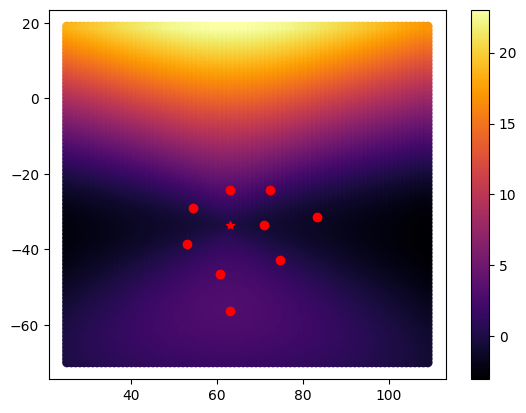

In [30]:
plt.scatter(yv,xv,c=(total_distance_haversin-total_distance)/1480,cmap='inferno')
plt.plot(med_lon, med_lat, c='r',marker='*')
plt.colorbar()
plt.scatter(pos[:,1],pos[:,0],c='r',marker='o')

/home/rsafran/PycharmProjects/toolbox/toolbox12.venv/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


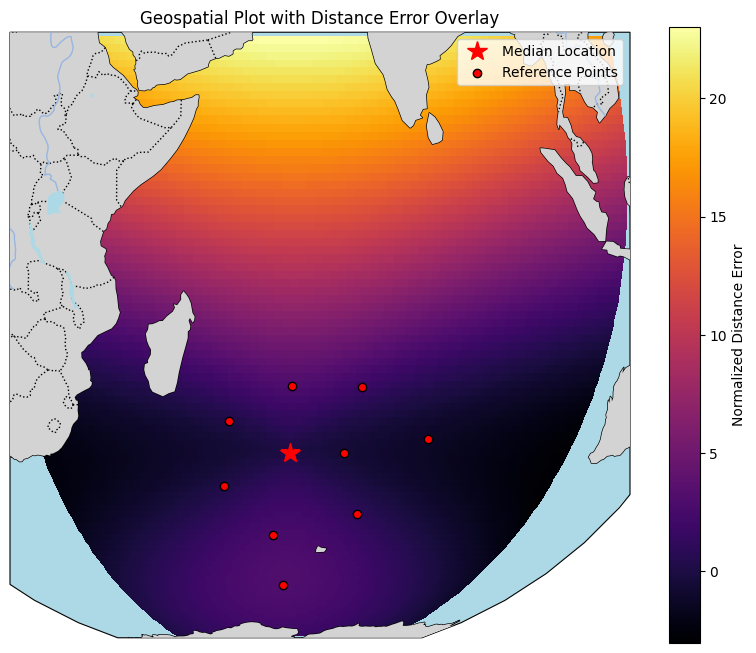

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Set up the figure with a PlateCarree projection (standard lat/lon)
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.Orthographic(central_longitude=60)})

# Add background map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':',zorder=4)
ax.add_feature(cfeature.LAND, facecolor='lightgray',zorder=3, alpha=1)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue',zorder=0)
ax.add_feature(cfeature.LAKES, facecolor='lightblue', zorder=5)
ax.add_feature(cfeature.RIVERS, zorder=5)

# Scatter plot with color coding
sc = ax.pcolormesh(yv,xv,(total_distance_gc-total_distance)/1480,cmap='inferno', transform=ccrs.PlateCarree())

# Add colorbar
plt.colorbar(sc, ax=ax, orientation='vertical', label='Normalized Distance Error')

# Plot median point
ax.plot(med_lon, med_lat, 'r*', markersize=15, transform=ccrs.PlateCarree(), label='Median Location')

# Overlay reference positions
ax.scatter(pos[:, 1], pos[:, 0], c='red', marker='o', edgecolor='k', transform=ccrs.PlateCarree(), label='Reference Points')

# Set extent (optional: zoom into region of interest)
buffer = 1  # degrees around data
ax.set_extent([
    min(yv.flatten()) - buffer, max(yv.flatten()) + buffer,
    min(xv.flatten()) - buffer, max(xv.flatten()) + buffer
], crs=ccrs.PlateCarree())

# Add title and legend
ax.set_title("Geospatial Plot with Distance Error Overlay")
ax.legend()

plt.show()
